## Este notebook apresenta a exploração dos dados após do pre-processamento

In [1]:
import pandas as pd
import re
import gensim
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial import distance

In [2]:
#setting parameters for data visualization
np.set_printoptions(threshold=None, precision=2)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('precision', 2)

In [3]:
#expand jupyter cells
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Opening movie reviews

In [4]:
messages = pd.read_csv('./chatdata/movie_lines_pre_processed_for_test.tsv', header = None, delimiter="\t", quoting=3, encoding='ISO-8859-2')

In [5]:
messages.columns = ['msg_line', 'user_id', 'movie_id', 'msg', 'msg_pre_processed', 'msg_2', 'target']

In [6]:
messages.head(10)

,msg_line,user_id,movie_id,msg,msg_pre_processed,msg_2,target
0,L49,u0,m0,Did you change your hair?,change hair,No.,1
1,L59,u9,m0,I missed you.,miss,It says here you exposed yourself to a group o...,0
2,L60,u8,m0,It says here you exposed yourself to a group o...,say expose group freshman girl,It was a bratwurst. I was eating lunch.,0
3,L61,u9,m0,It was a bratwurst. I was eating lunch.,bratwurst eat lunch,With the teeth of your zipper?,0
4,L63,u7,m0,You the new guy?,new guy,So they tell me...,1
5,L64,u2,m0,So they tell me...,tell,C'mon. I'm supposed to give you the tour.,0
6,L66,u7,m0,So -- which Dakota you from?,dakota,North actually. How'd you ?,1
7,L67,u2,m0,North actually. How'd you ?,north actually howd,I was kidding. People actually live there?,1
8,L68,u7,m0,I was kidding. People actually live there?,kid people actually live,Yeah. A couple. We're outnumbered by the cows ...,1
9,L69,u2,m0,Yeah. A couple. We're outnumbered by the cows ...,yeah couple outnumber cow though,How many people were in your old school?,0


### Print profile

- All fields with data in all rows
- The number of answer is bigger than questions, but the neural network will be trained using the 'stratify' parameter to keep the proportionality of data in train dataset

In [7]:
from pandas_profiling import ProfileReport

In [8]:
profile = ProfileReport(messages, title="Pandas Profiling Report")

In [9]:
profile

### Data exploration

In [10]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   msg_line           30000 non-null  object
 1   user_id            30000 non-null  object
 2   movie_id           30000 non-null  object
 3   msg                30000 non-null  object
 4   msg_pre_processed  30000 non-null  object
 5   msg_2              30000 non-null  object
 6   target             30000 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 1.6+ MB


In [11]:
messages.describe()

,target
count,30000.00
mean,0.32
std,0.47
min,0.00
25%,0.00
50%,0.00
75%,1.00
max,1.00


#### Data Analysis based on this article
- https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools?utm_source=medium&utm_medium=crosspost&utm_campaign=blog-exploratory-data-analysis-natural-language-processing-tools

In [12]:
data = messages['msg_pre_processed']

### Number of characters of each message
- The number of characters are between 0 and 400
- The majority of messages are between 0 and 100

<AxesSubplot:>

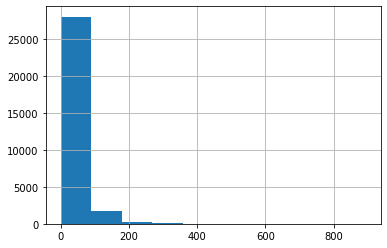

In [13]:
#histogram to display the number of character of each message
data.str.len().hist()

## Value types
- the messages are just strings

In [14]:
#checking the average word length
data_set = [type(item) for item in data]
data_set = set(data_set)
data_set

{str}

## Print float values

In [15]:
float_val = [it for it in data if isinstance(it, float)]
print(len(float_val))
float_val = set(float_val)
print(float_val)

0
set()


In [16]:
messages[messages['msg_pre_processed'].isna()]

,msg_line,user_id,movie_id,msg,msg_pre_processed,msg_2,target


### Removing non-alphabetical messages (not used)

### Number of words for each message
- the majority os messages is in 0 to 100 words

<AxesSubplot:>

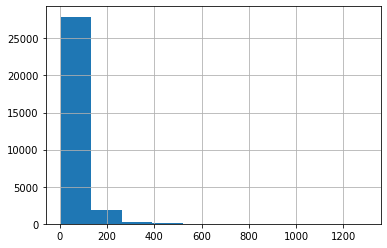

In [17]:
#number of words for each message
data.str.split(' ').\
    map(lambda x: len(str(x))).\
    hist()

The number of words are between 0 and 100

### Average word length
- The length of words goes from 0 to 20
- the majority is from 0 to ~8

<AxesSubplot:>

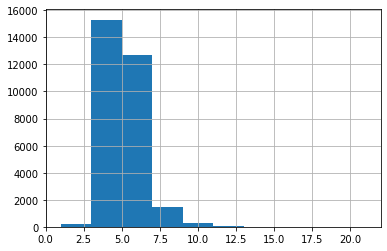

In [18]:
#checking the average word length
data.str.split(' ').\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

### Distribuition of stopwords in the mesages
- all the stopwords were removed in pre-precessing

In [19]:
import nltk
from nltk.corpus import stopwords

In [20]:
#checkig the distribuition of stopwrds in the mesages
stop=set(stopwords.words('english'))
corpus=[]
msg_ = data.str.split()
msg_ = msg_.values.tolist()
corpus=[word for i in msg_ for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

In [21]:
len(list(dic.values()))

0

In [22]:
import matplotlib.pyplot as plt

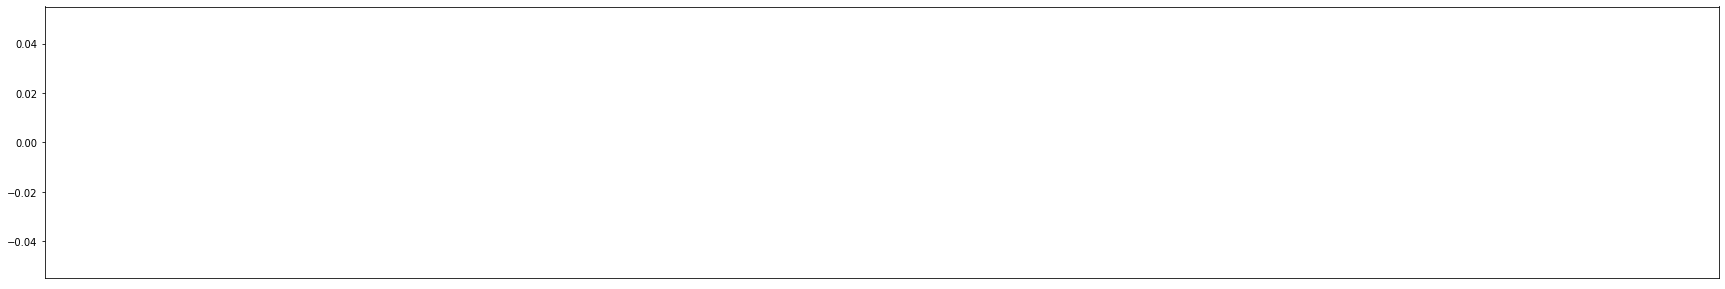

In [23]:
x = dic.keys()
y = dic.values()
plt.subplots(figsize=(30,5))
plt.bar(x, y, 1, color='b')
plt.xticks(list(x), rotation=90, fontsize=14)
plt.show()

The majority of stop words are 'to', 'you', 'the' and 'a'

### Occurences of each word
- the words 'get' and 'know' are the most common

In [24]:
from collections import Counter
import seaborn as sns

<AxesSubplot:>

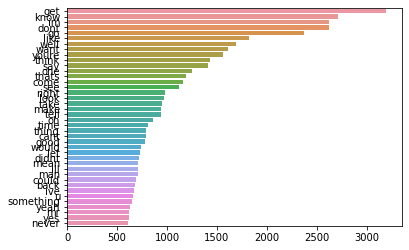

In [25]:
#ploting the occurences of each word
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

The word 'I' has the biggest occurrence. There are a lot of messages like dashes that can be removed

### Get the most frequent n-grams
- again, all the n-grams shows fragments of informal conversation

In [26]:
from nltk.util import ngrams

In [27]:
#get the most frequent n-grams
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

In [28]:
def plot_n_gram(corpus, n=2):
    top_n_bigrams=get_top_ngram(corpus,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

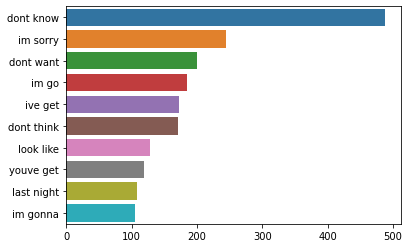

In [29]:
plot_n_gram(data, 2)

The more frequent bigram is 'you re'

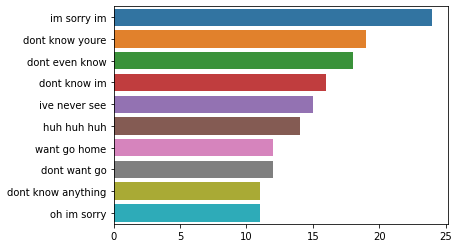

In [30]:
plot_n_gram(data, 3)

There are a lot of short questions like 'what do you...?', 'what are you...?', and answers like 'you want to...'

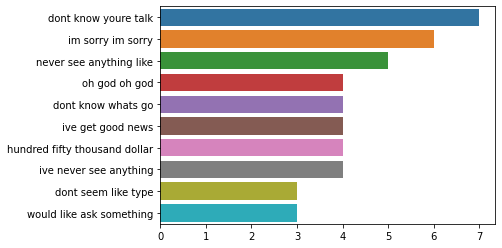

In [31]:
plot_n_gram(data, 4)

There are a lot of repeated questions and answers or part of them

### Sentimental analysis
- the messages are in majority neutral (close to 0), but there are some negative and positive ones
- the Page Rank algoritm will try to put the more relevant messages in the top of the list

In [32]:
from textblob import TextBlob

In [33]:
#checkig the polarity of the messages
def polarity(text):
    return TextBlob(text).sentiment.polarity

<AxesSubplot:>

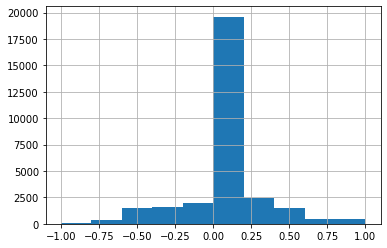

In [34]:
messages['polarity_score']=data.\
   apply(lambda x : polarity(x))
messages['polarity_score'].hist()

The majority of polarity is neutral

### Named entity recognition
- a big number of PERSON entities was found, so, possibly because the conversations have name of people like Bianca, Regina

- TYPE	DESCRIPTION
- PERSON	People, including fictional.
- NORP	Nationalities or religious or political groups.
- FAC	Buildings, airports, highways, bridges, etc.
- ORG	Companies, agencies, institutions, etc.
- GPE	Countries, cities, states.
- LOC	Non-GPE locations, mountain ranges, bodies of water.
- PRODUCT	Objects, vehicles, foods, etc. (Not services.)
- EVENT	Named hurricanes, battles, wars, sports events, etc.
- WORK_OF_ART	Titles of books, songs, etc.
- LAW	Named documents made into laws.
- LANGUAGE	Any named language.
- DATE	Absolute or relative dates or periods.
- TIME	Times smaller than a day.
- PERCENT	Percentage, including ”%“.
- MONEY	Monetary values, including unit.
- QUANTITY	Measurements, as of weight or distance.
- ORDINAL	“first”, “second”, etc.
- CARDINAL	Numerals that do not fall under another type.

In [35]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [36]:
#transform the messages in a big document
def get_entities(corpus, int_limit=0, end_limit=100):
    msg_all = ' '.join(data[int_limit:end_limit])
    doc = nlp(msg_all)

    entity_list = [(x.text,x.label_) for x in doc.ents]
    
    return entity_list

In [37]:
%%time

ent_list = set()
skip = 1000
i = 0
lim = len(data)
#lim = 20000

while(i < lim):    
    ent_list = set(get_entities(data, i, i+skip))
    ent_list.union(ent_list)
    i = i + skip
    print('Processed '+str(i)+' of '+str(lim)+' messages')

Processed 1000 of 30000 messages
Processed 2000 of 30000 messages
Processed 3000 of 30000 messages
Processed 4000 of 30000 messages
Processed 5000 of 30000 messages
Processed 6000 of 30000 messages
Processed 7000 of 30000 messages
Processed 8000 of 30000 messages
Processed 9000 of 30000 messages
Processed 10000 of 30000 messages
Processed 11000 of 30000 messages
Processed 12000 of 30000 messages
Processed 13000 of 30000 messages
Processed 14000 of 30000 messages
Processed 15000 of 30000 messages
Processed 16000 of 30000 messages
Processed 17000 of 30000 messages
Processed 18000 of 30000 messages
Processed 19000 of 30000 messages
Processed 20000 of 30000 messages
Processed 21000 of 30000 messages
Processed 22000 of 30000 messages
Processed 23000 of 30000 messages
Processed 24000 of 30000 messages
Processed 25000 of 30000 messages
Processed 26000 of 30000 messages
Processed 27000 of 30000 messages
Processed 28000 of 30000 messages
Processed 29000 of 30000 messages
Processed 30000 of 3000

In [38]:
len(ent_list)

208

In [39]:
ent_list

{('100 percent', 'PERCENT'),
 ('13th street', 'FAC'),
 ('1862', 'DATE'),
 ('4060', 'DATE'),
 ('5149', 'CARDINAL'),
 ('6040', 'CARDINAL'),
 ('702', 'CARDINAL'),
 ('711', 'CARDINAL'),
 ('73', 'CARDINAL'),
 ('9', 'CARDINAL'),
 ('95 percent', 'PERCENT'),
 ('abe lincoln', 'PERSON'),
 ('abraham lincoln', 'PERSON'),
 ('agentmy technosingle', 'PERSON'),
 ('amall time', 'PERSON'),
 ('american', 'NORP'),
 ('amnesia', 'NORP'),
 ('amnesia', 'PERSON'),
 ('amy', 'ORG'),
 ('andy', 'PERSON'),
 ('andy stone', 'PERSON'),
 ('arkansas', 'GPE'),
 ('atlanta', 'GPE'),
 ('babe', 'PERSON'),
 ('beatin', 'PERSON'),
 ('billy sherbert', 'PERSON'),
 ('british', 'NORP'),
 ('brotherinlaw', 'PERSON'),
 ('bush', 'PERSON'),
 ('cactus', 'ORG'),
 ('cape', 'PERSON'),
 ('charlie', 'PERSON'),
 ('chase tail nighti', 'ORG'),
 ('christmas', 'DATE'),
 ('christmas eve', 'DATE'),
 ('chuck noland', 'PERSON'),
 ('clark', 'PERSON'),
 ('comp least two', 'CARDINAL'),
 ('county commission', 'ORG'),
 ('couple minute', 'TIME'),
 ('cowboy'

There are some personal names, real locals, name of organizations and work of art that can be removed or replaced for generic terms. 

In [40]:
ent_df = pd.DataFrame(list(ent_list))

In [41]:
ent_df

,0,1
0,sendin nicky,PERSON
1,sam babysitter,PERSON
2,nut,ORG
3,couple minute,TIME
4,cowboy,ORG
5,100 percent,PERCENT
6,county commission,ORG
7,hundred million year,DATE
8,chuck noland,PERSON
9,threemonth,DATE


### Entity frequency
- there are still some words tagged as PERSON, but the number decreased from 50000 to 4000
- the algorithm of clening need more tunning, but for now this result will be accepted

In [42]:
def ner(text):
    doc=nlp(text)
    return [X.label_ for X in doc.ents]

In [43]:
%%time
#count the number of each entity
ent=data.\
    apply(lambda x : ner(x))
ent=[x for sub in ent for x in sub]

counter=Counter(ent)
count=counter.most_common()

CPU times: user 5min 17s, sys: 1.11 s, total: 5min 18s
Wall time: 5min 27s


<AxesSubplot:>

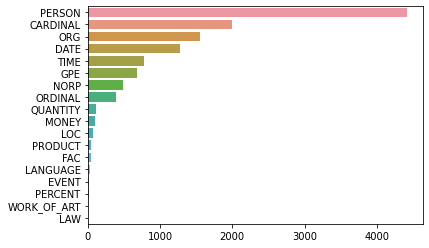

In [44]:
x,y=map(list,zip(*count))
sns.barplot(x=y,y=x)

### Most comon tokens per entity

In [45]:
def ner(text,ent="PERSON"):
    doc=nlp(text)
    return [X.text for X in doc.ents if X.label_ == ent]

In [46]:
%%time
#count the tokens for a given entity type
gpe=data.apply(lambda x: ner(x, 'PERSON'))
gpe=[i for x in gpe for i in x]
counter=Counter(gpe)

CPU times: user 5min 43s, sys: 1.25 s, total: 5min 44s
Wall time: 5min 54s


/home/douglas/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

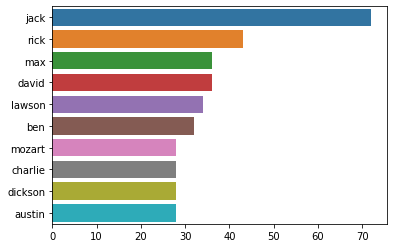

In [47]:
x,y=map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

## Parts of Speach Tagging
- as the result of Entity, the bisgest number of tags is NN (Noun)

There are eight main parts of speech:

- Noun (NN)- Joseph, London, table, cat, teacher, pen, city
- Verb (VB)- read, speak, run, eat, play, live, walk, have, like, are, is
- Adjective(JJ)- beautiful, happy, sad, young, fun, three
- Adverb(RB)- slowly, quietly, very, always, never, too, well, tomorrow
- Preposition (IN)- at, on, in, from, with, near, between, about, under
- Conjunction (CC)- and, or, but, because, so, yet, unless, since, if
- Pronoun(PRP)- I, you, we, they, he, she, it, me, us, them, him, her, this
- Interjection (INT)- Ouch! Wow! Great! Help! Oh! Hey! Hi!

In [48]:
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/douglas/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [49]:
def remove_duplicated_spaces(corpus):
    #remove duplicated spaces
    corpus_alt = re.sub(r' +', ' ', corpus)

    return corpus_alt

In [50]:
msg_no_space = [remove_duplicated_spaces(str(m)) for m in data]
msg_no_space = pd.Series(msg_no_space)

In [51]:
def pos(text):
    #matched = re.match(r" +", text)
    if text != ' ':
        #print(text)
        pos=nltk.pos_tag(word_tokenize(text))
        #print(pos)
        pos=list(map(list,zip(*pos)))[1]
        return pos
    return

In [52]:
%%time
tags=msg_no_space[0:5000].apply(lambda x : pos(x))
#tags = [pos(m) for m in msg_no_space[0:10000]]
#tags
tags=[x for l in tags for x in l]
counter=Counter(tags)

CPU times: user 4.73 s, sys: 656 ms, total: 5.39 s
Wall time: 7.66 s


<AxesSubplot:>

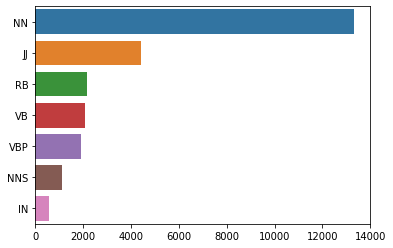

In [53]:
x,y=list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

In [60]:
### most commonly nouns
def get_adjs(text, _tag='NN'):
    adj=[]
    pos=nltk.pos_tag(word_tokenize(text))
    for word,tag in pos:
        if tag == _tag:
            adj.append(word)
    return adj

In [61]:
%%time
words=data.apply(lambda x : get_adjs(x))
words=[x for l in words for x in l]
counter=Counter(words)

CPU times: user 25.1 s, sys: 1.98 s, total: 27 s
Wall time: 27.7 s


<AxesSubplot:>

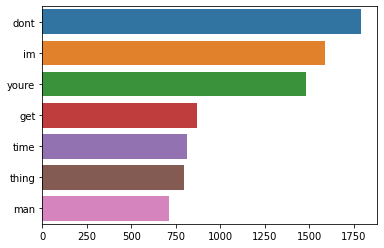

In [62]:
x,y=list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

## Text complexy
- the text now is a little bit more complexy

Flesch Reading Ease (FRE)
<br>Higher scores indicate material that is easier to read, lower numbers mark harder-to-read passages:
- 0-30 College
- 50-60 High school
- 60+ Fourth grade

In [63]:
from textstat import flesch_reading_ease

CPU times: user 2.56 s, sys: 15.6 ms, total: 2.58 s
Wall time: 2.64 s


<AxesSubplot:>

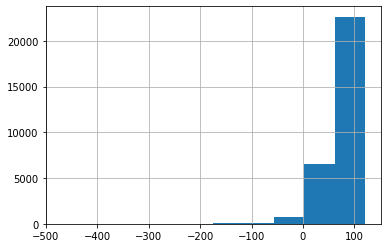

In [64]:
%%time
reading = data.\
   apply(lambda x : flesch_reading_ease(x))
reading.hist()

The text is easy to read

In [65]:
x=[i for i in range(len(reading)) if reading[i]<0]

messages.iloc[x]['msg_pre_processed'].head()

11                          thirtytwo
22                        tempestuous
80               conversation purpose
202             completely unbalanced
211    extremely unfortunate maneuver
Name: msg_pre_processed, dtype: object